# Base Model

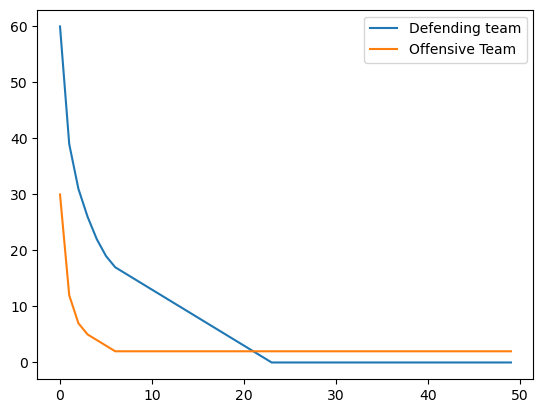

In [97]:
import numpy as np
import matplotlib.pyplot as plt

x_i1 = lambda a, x_i, y_i: x_i - a*y_i
y_i1 = lambda b, x_i, y_i: y_i - b*x_i*y_i

def gw_discrete_time(IC, params, n = 50):
    x, y = np.zeros(n), np.zeros(n)
    a, b = params[0], params[1]
    x[0], y[0] = IC[0], IC[1]
    t = np.zeros(n)

    for i in range(1,n):
        x[i] = round(x_i1(a, x[i-1], y[i-1]))
        if x[i] < 0: x[i] = 0
        y[i] = round(y_i1(b, x[i-1], y[i-1]))
        if y[i] < 0: y[i] = 0
        t[i] = i
    
    return t, x, y

IC = (60, 30)
params = (0.7, 0.01)

t, x, y = gw_discrete_time(IC, params)

plt.plot(t, x, label = "Defending team")
plt.plot(t, y, label = "Offensive Team")
plt.legend()
plt.show()

# Markov Chain Representation

In [98]:
def markov_generator(IC, params):
    x0, y0 = IC[0], IC[1]
    length = (x0 + 1)*(y0 + 1)
    a, b = params[0], params[1]
    M = np.zeros((length, length))
    for i in range(length):
        x = i//(y0 + 1)
        y = i%(y0 + 1)
        if x > 0 and y > 0:
            x_prob = a*y
            y_prob = b*x*y
            total_prob = x_prob + y_prob
            M[i][i - y0 - 1] = x_prob/total_prob
            M[i][i - 1] = y_prob/total_prob
        else: #If the state is absorbing, always stay at that state
            M[i][i] = 1
    return M


def extract_canonical_components(M):
    D = np.diag(M)
    absorbing, transient = np.where(D==1)[0], np.where(D!=1)[0]
    I = M[absorbing, :][:, absorbing]
    Q = M[transient, :][:, transient]
    R = M[transient, :][:, absorbing]
    O = M[absorbing, :][:, transient]
    return I, Q, R, O, absorbing, transient

def fundamental_matrix(M):
    I, Q, R, O, absorbing, transient = extract_canonical_components(M)
    N = np.linalg.inv(np.eye(len(Q))-Q)
    return N, transient

IC = [65, 20]
M = markov_generator(IC, params)
N, transient = fundamental_matrix(M)

[1890, 1859, 1858, 1827, 1796, 1765, 1764, 1763, 1732, 1701, 1670, 1669, 1668, 1667, 1636, 1605, 1574, 1543, 1512, 1481, 1450, 1419, 1418, 1417, 1386, 1355, 1354, 1323, 1292, 1261, 1230, 1229, 1198, 1167, 1136, 1105, 1074, 1043, 1012, 981, 980, 979, 978, 947, 916, 885, 884, 853, 852, 851, 850, 819, 788, 757, 756, 725, 694, 663, 632, 601, 570, 539, 508, 507, 476, 445, 414, 383, 352, 321, 290, 289, 288, 257, 226, 225, 194, 163, 132, 101, 70, 39, 8, 8]


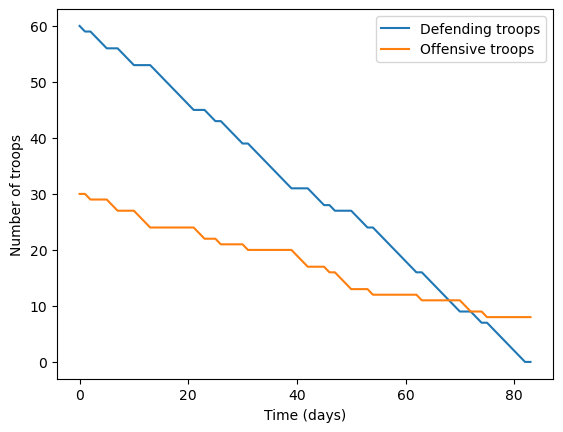

In [99]:
def simulate_conflict(M, IC, max_iter = 100):
    x0, y0 = IC[0], IC[1]
    pos = [len(M) - 1]
    x, y, t = [x0], [y0], [0]
    for i in range(max_iter): 
        pos_next = np.random.choice(len(M), p = M[pos[-1]])
        # print(pos_next//(y0 +1), pos_next%(y0+1))
        x.append(pos_next//(y0 +1))
        y.append(pos_next%(y0+1))
        t.append(i + 1)
        if pos_next == pos[-1]:
            return pos + [pos_next], t, x, y
        else:
            pos += [pos_next]
    return -1

IC = (60, 30)
params = (0.62, 0.01)
M = markov_generator(IC, params)
sol, t, x, y = simulate_conflict(M, IC)
print(sol)
plt.plot(t, x, label = "Defending troops")
plt.plot(t, y, label = "Offensive troops")
plt.xlabel("Time (days)")
plt.ylabel("Number of troops")
plt.legend()
plt.show()

# Monte Carlo Simulation

In [100]:
def monte_carlo(M, IC, max_iter = 100, n = 5000, verbose = False):
    x_winners = []
    y_winners = []
    x_wins = 0
    conflict_lengths = []
    for i in range(1, n):
        if verbose: print('Simulating conflict {0}'.format(i))
        sol, _, x, y = simulate_conflict(M, IC, max_iter = max_iter)
        if x[-1] == 0:
            y_winners.append(y[-1])
        else:
            x_winners.append(x[-1])
            x_wins += 1
        conflict_lengths.append(len(sol) - 2)
    y_wins = n - x_wins
    print(sum(conflict_lengths)/n)
    print(sum(x_winners)/x_wins, sum(y_winners)/y_wins)
    return x_wins, y_wins
mc_simulation = monte_carlo(M, IC)
print(mc_simulation)

75.7308
23.506136267456622 5.957906712172924
(2363, 2637)
